In [134]:
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [281]:
class Item:
    
    # Initializer/Instance Attributes
    def __init__(self, K, h, U, S, L, period, length):
        self.K = K # setup cost; cost per order
        self.h = h # holding cost per unit per period
        self.U = U # unit cost
        self.S = S # sale cost
        self.L = L # lead time
        self.period = period # 'W' or 'M'
        self.length = length
        
        self.current_inventory = 180
        
        # cost arrays
        self.revenues = np.zeros(self.length)
        self.holding_cost = np.zeros(self.length)
        self.setup_cost = np.zeros(self.length)
        self.ordering_cost = np.zeros(self.length)
        self.lost_sales = np.zeros(self.length)
        self.total_revenues = np.zeros(self.length)
        
    def _silver_meal(self, planned_demand):
        # initialize parameters
        n = len(planned_demand)
        cpp = [self.K] # cost per period
        j = 0
        order_idx = []
    
        # SM heuristic
        for i in range(n-1):
            cpp.append((j+1)/(j+2) * (cpp[j] + self.h*planned_demand[i+1]))
            j += 1
                   
            if cpp[j] > cpp[j-1]:
                order_idx.append(i+1)
                # start per-period analysis over since an order has been scheduled
                cpp = [self.K]
                j = 0 
    
        # compute quantities to order
        order_qty = np.zeros(n)
        prev_idx = 0
        order_idx.append(n)
    
        for idx in order_idx:
            order_qty[prev_idx] = np.sum(planned_demand[prev_idx:idx])
            prev_idx = idx
    
        return order_qty
    
    def _purchase_orders(self, planned_demand):
        
        # Case 1: stockout happens before our chance to replenish inventory (lead time too large)
        for i in range(self.length):
            penury = self.current_inventory - np.sum(planned_demand[:i+1])
            if penury < 0:
                pen_idx = i
                break
        SM = self._silver_meal(planned_demand[pen_idx:])
        
        if self.L + len(SM) + 1 > self.length: # stockout inevitable
            print('stockout inevitable')
            self.order_receipt = np.concatenate([ pen_idx * [0], SM ])
            self.order_receipt[:self.L] = 0 # stockout is inevitable so we cannot order in time
            self.purchase_order = np.roll(self.order_receipt, -self.L)
            self.purchase_order[-self.L:] = 0
            if self.purchase_order[0] == 0: # then do just in time until next order arrives
                idx = next((index for index, value in enumerate(self.purchase_order) if value != 0), None)
                self.order_receipt[self.L] = np.sum(planned_demand[self.L:idx+self.L])  
                self.purchase_order[0] = self.order_receipt[self.L]
        else:
        # Case 2: we have time to replenish the inventory before the stockout happens
            print('no stockout')
            self.order_receipt = self._silver_meal(planned_demand)
            self.order_receipt[:self.L] = 0 # we don't have time to order these quantities
            self.purchase_order = np.concatenate([self.order_receipt[self.L:], self.L * [0]])
    
    def _inventory_levels(self, planned_demand):
        self.ending_balance = np.zeros(self.length)
        I = np.zeros(self.length + 1)
        I[0] = self.current_inventory
        for i in range(self.length):
            self.ending_balance[i] = I[i] + self.order_receipt[i] - planned_demand[i]
            I[i+1] = np.maximum(self.ending_balance[i], 0)
        self.inventory_levels = I[1:]
    
    def _costs(self, planned_demand):
        self.holding_cost = self.h * self.inventory_levels
        self.setup_cost = self.K * np.heaviside(self.purchase_order, 0)
        self.ordering_cost = self.U * self.purchase_order
        self.revenues = self.S * np.minimum(planned_demand, planned_demand + self.ending_balance)
        self.lost_sales = np.minimum(self.S * self.ending_balance, 0)
        
        self.total_revenues = np.sum(self.revenues + self.lost_sales - 
                                    (self.holding_cost + self.setup_cost + self.ordering_cost))
        
    def update_demand(self, planned_demand):
        self._purchase_orders(planned_demand)
        self._inventory_levels(planned_demand)
        self._costs(planned_demand)

In [282]:
sku1 = Item(K=100, h=0.35, U=7, S=25, L=2, period='W', length=12)
demand = np.array([80, 65, 20, 50, 90, 80, 60, 25, 70, 30, 40, 75])
sku1.update_demand(demand)

sku1.total_revenues
sku1.ending_balance

no stockout


12882.25

array([100.,  35.,  15., 185.,  95.,  15., 140., 115.,  45.,  15.,  90.,
        15.])

In [284]:
sku1._purchase_orders(demand)
sku1.purchase_order

no stockout


array([  0., 220.,   0.,   0., 185.,   0.,   0.,   0., 115.,   0.,   0.,
         0.])

In [278]:
sku1._silver_meal(demand)

array([165.,   0.,   0., 220.,   0.,   0., 185.,   0.,   0.,   0., 115.,
         0.])

In [198]:
silver_meal([50, 90, 80, 60, 25, 70, 30, 40, 75], 100, 0.35)

array([220.,   0.,   0., 185.,   0.,   0.,   0., 115.,   0.])

In [71]:
demand[:1]

array([80])

In [83]:
for i in range(len(demand)):
    penury = 150 - np.sum(demand[:i+1])
    if penury < 0:
        print(i)
        break
print(i)
silver_meal(demand[i:], 100, 0.35)

2
2


array([ 70.,   0., 255.,   0.,   0.,   0., 140.,   0.,   0.,  75.])

In [89]:
np.roll([0, 0, 0, 220.,   0.,   0., 185.,   0.,   0.,   0., 115.,   0.], -4)

array([  0.,   0., 185.,   0.,   0.,   0., 115.,   0.,   0.,   0.,   0.,
       220.])

In [96]:
myList = [0.,   0.,   0., 185.,   0.,   0.,   0., 115.,   0.]

In [97]:
val = next( (index for index, value in enumerate(myList) if value != 0), None )
print(val)

3


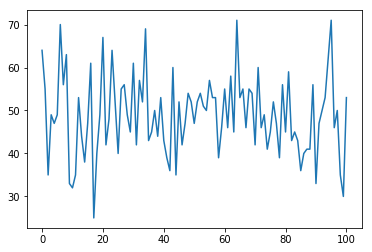

In [241]:
import matplotlib.pyplot as plt 

t = np.linspace(0, 100, num=101)
y = np.round(50 + 10*np.random.randn(t.size))

plt.plot(t, y)
plt.show()

In [248]:
sku2 = Item(K=100, h=0.35, U=7, S=25, L=10, period='W', length=101)
demand = np.array(y)
sku2.get_purchase_orders(demand);
sku2.get_inventory_levels(demand);
sku2.compute_costs(demand)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.,
        170.,   0.,   0.,   0., 173.,   0.,   0.,   0., 206.,   0.,   0.,
          0., 156.,   0.,   0., 205.,   0.,   0.,   0., 160.,   0.,   0.,
        209.,   0.,   0.,   0., 190.,   0.,   0.,   0., 170.,   0.,   0.,
          0., 141.,   0.,   0., 153.,   0.,   0., 157.,   0.,   0., 160.,
          0.,   0., 138.,   0.,   0., 204.,   0.,   0.,   0., 225.,   0.,
          0.,   0., 151.,   0.,   0., 196.,   0.,   0.,   0., 183.,   0.,
          0.,   0., 203.,   0.,   0.,   0., 164.,   0.,   0.,   0., 171.,
          0.,   0.,   0., 150.,   0.,   0., 179.,   0.,   0., 115.,   0.,
          0.,  53.]),
 array([ 32., 170.,   0.,   0.,   0., 173.,   0.,   0.,   0., 206.,   0.,
          0.,   0., 156.,   0.,   0., 205.,   0.,   0.,   0., 160.,   0.,
          0., 209.,   0.,   0.,   0., 190.,   0.,   0.,   0., 170.,   0.,
          0.,   0., 141.,   0.,   0., 153.,   0.,   0., 157.,   0.,   0.,
        160.,   

(array([116.,  61.,  26.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        135.,  82.,  38.,   0., 126.,  65.,  40.,   0., 157.,  90.,  48.,
          0.,  92.,  40.,   0., 150.,  94.,  45.,   0.,  99.,  57.,   0.,
        157.,  88.,  45.,   0., 140.,  96.,  43.,   0., 131.,  95.,  35.,
          0.,  89.,  47.,   0.,  99.,  47.,   0., 105.,  51.,   0., 110.,
         53.,   0.,  85.,  46.,   0., 149., 103.,  45.,   0., 154., 101.,
         46.,   0.,  96.,  42.,   0., 136.,  90.,  41.,   0., 138.,  86.,
         39.,   0., 147., 102.,  43.,   0., 119.,  76.,  40.,   0., 130.,
         89.,  33.,   0., 103.,  53.,   0., 117.,  46.,   0.,  65.,  30.,
          0.,   0.]),
 array([116.,  61.,  26., -23., -47., -49., -70., -56., -63., -33.,   0.,
        135.,  82.,  38.,   0., 126.,  65.,  40.,   0., 157.,  90.,  48.,
          0.,  92.,  40.,   0., 150.,  94.,  45.,   0.,  99.,  57.,   0.,
        157.,  88.,  45.,   0., 140.,  96.,  43.,   0., 131.,  95.,  35.,
          0.,  8

70773.3


In [238]:
demand

array([55., 43., 59., 34., 48., 39., 60., 74., 48., 64., 48., 28.])

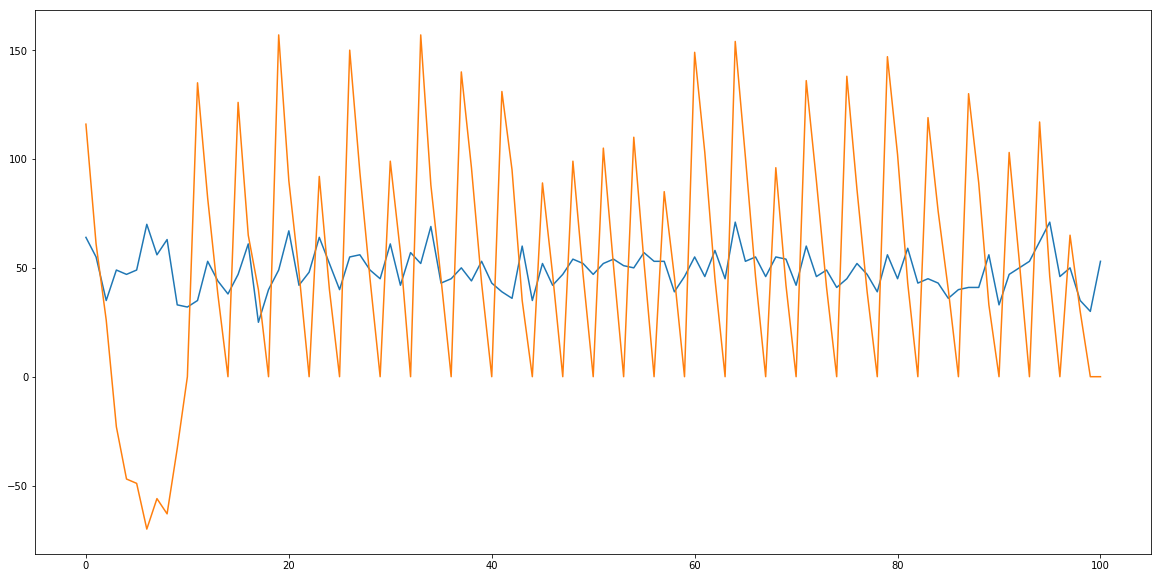

In [249]:
plt.figure(figsize=(20,10))
plt.plot(t, y, t, sku2.get_inventory_levels(demand)[1])